In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation 
import time
import scipy as sp
import pyamg
from tqdm.notebook import tqdm

In [32]:
# A brief rundown on whats going on here. The whole code is split into 3 parts; the solvers, initialization and postprocessing

# Solvers:
#     upwind1: 1st order upwind
#     quick3: 3rd order deferred QUICK
#     MUSCL3: 3rd order MUSCL with minmod limiter
#     mom: discretise NS eqns and solves them.
#     face: calculate face velocities using Rhie & Chow interpolation
#     cont: set ups and solve the continuity eqn to get pressure correction
#     correct: correct the nodal velocities and pressure. (Would be nice if someone explain to me why face velocities need to
#                                                         be corrected, even though here it is not done and this code is still
#                                                         able to get decently accurate results)
# Initialization:
#     Here you just set up the domain length, mesh sizes, relaxation factors, inlet velocities etc 
    
# Solution:
#     Just solves the NS eqns, you can finetune the residual requirement
    
# Post-Processing:
#     Colorful graphs or animations (reminder to run the %matplotlib notebook cell if want to play animations 
#                                    for transient flow)

    
# A bit more details on the mom solver:
#     Variables and their meanings:
#         b: aspect ratio, dy/dx (even though its there, the code can only run on square cells, has not been a major enough
#                                problem for me to find the error and solve it)
            
#         a1: eastern face flux from previous iteration
#         a2: western face flux from previous iteration
#         e1: northern face flux from previous iteration
#         e2: southern face flux from previous iteration
#         Nx_in: index 'length' of the blockage
#         Ny_in: index 'height' of the blockage
            
#     Discretisation methods:
        
#     Diffusion: 4th order central difference
#     Convection: Pick and choose (upwind1,quick3 and MUSCL3 is here, you can just find and replace the functions if you
#                                 want to convert it)
#     Boundary cells: 3rd order forward/backward differencing
        
#     You will notice some lines of code that look like this (UWW=4*UW-6*UP+4*UE-UEE). They are just cubic extrapolations
#     to create a ghost cell. As higher order schemes have a larger stencil, the cells next to boundary cells will need ghost
#     cells to if you want to continue using 4th order CD for example. 
                                                         
#     Moreover, you will notice I updated the source terms for such cells. This is due to the fact those ghost cells are
#     just ficticious and solving them implicitly will result in index error. 
    
#     Time: Being lazy here so i just put conditional statements, that goes from 1st order forward euler to 4th order 
#         Adams-Bashforth
    
                                                    
#     I hope this is enough to roughly understand what is going on. This code is by no means efficient but it gets the job
#     done decently well.
    

In [24]:
%matplotlib notebook

In [33]:
def upwind1(AE,AW,AN,AS,AP,uBP,vBP,a1,a2,e1,e2,UE,UW,UEE,UWW,UEEE,UWWW,UP,VN,VS,VNN,VSS,VNNN,VSSS,VP):
    global b
    
    ue=a1
    uw=a2
    vn=e1
    vs=e2
 
    a1b=a1*b
    a2b=a2*b

    AP+=a1b*(abs(ue)+ue)
    AE+=a1b*(abs(ue)-ue)

    AP-=a2b*(abs(uw)-uw)
    AW-=a2b*(abs(uw)+uw)

    AP+=e1*(abs(vn)+vn)
    AN+=e1*(abs(vn)-vn)

    AP-=e2*(abs(vs)-vs)
    AS-=e2*(abs(vs)+vs)
            
    return AE,AW,AN,AS,AP,uBP,vBP

In [34]:
def quick3(AE,AW,AN,AS,AP,uBP,vBP,a1,a2,e1,e2,UE,UW,UEE,UWW,UP,VN,VS,VNN,VSS,VP):
    global b
    global defer
    
    uBP0=uBP
    vBP0=vBP
    ue=a1
    uw=a2
    vn=e1
    vs=e2
    
    if ue!=0:
        if ue>0:
            AP+=2*a1*b
            uBP-=a1*b*(3*UE-2*UP-UW)/4
            vBP-=a1*b*(3*UE-2*UP-UW)/4
        else:
            AE+=2*a1*b
            uBP-=a1*b*(3*UP-2*UE-UEE)/4
            vBP-=a1*b*(3*UP-2*UE-UEE)/4
    if uw!=0:
        if uw<0:
            AP-=2*a2*b
            uBP+=a2*b*(3*UW-2*UP-UE)/4
            vBP+=a2*b*(3*UW-2*UP-UE)/4
        else:
            AW-=2*a2*b
            uBP+=a2*b*(3*UP-2*UW-UWW)/4
            vBP+=a2*b*(3*UP-2*UW-UWW)/4
    if vn!=0:
        if vn>0:
            AP+=2*e1
            uBP-=e1*(3*VN-2*VP-VS)/4
            vBP-=e1*(3*VN-2*VP-VS)/4
        else:
            AN+=2*e1
            uBP-=e1*(3*VP-2*VN-VNN)/4
            vBP-=e1*(3*VP-2*VN-VNN)/4
    if vs!=0:
        if vs<0:
            AP-=2*e2
            uBP+=e2*(3*VS-2*VP-VN)/4
            vBP+=e2*(3*VS-2*VP-VN)/4
        else:
            AS-=2*e2
            uBP+=e2*(3*VP-2*VS-VSS)/4
            vBP+=e2*(3*VP-2*VS-VSS)/4
            
    if defer==False:
        return AE,AW,AN,AS,AP,uBP0,vBP0
    else:
        return AE,AW,AN,AS,AP,uBP,vBP

In [35]:
def MUSCL3(AE,AW,AN,AS,AP,uBP,vBP,a1,a2,e1,e2,UE,UW,UEE,UWW,UP,VN,VS,VNN,VSS,VP):
    global b
    global iter_count
    
    uBP0=uBP
    vBP0=vBP
    ue=a1
    uw=a2
    vn=e1
    vs=e2
    
    if ue!=0:
        if ue>0:
            AP+=2*a1*b
            
            r=(UP-UW)/(UE-UP)
            limit=np.min([r,1])
            flux=(UP-UW)/6+(UE-UP)/3

            uBP-=a1*b*limit*flux
            vBP-=a1*b*limit*flux
        else:
            AE+=2*a1*b

            r=(UE-UEE)/(UP-UE)
            limit=np.min([r,1])
            flux=(UE-UEE)/6+(UP-UE)/3

            uBP-=a1*b*limit*flux
            vBP-=a1*b*limit*flux
    if uw!=0:
        if uw<0:
            AP-=2*a2*b

            r=(UP-UE)/(UW-UP)
            limit=np.min([r,1])
            flux=(UP-UE)/6+(UW-UP)/3

            uBP+=a2*b*limit*flux
            vBP+=a2*b*limit*flux
        else:
            AW-=2*a2*b

            r=(UW-UWW)/(UP-UW)
            limit=np.min([r,1])
            flux=(UW-UWW)/6+(UP-UW)/3

            uBP+=a2*b*limit*flux
            vBP+=a2*b*limit*flux
    if vn!=0:
        if vn>0:
            AP+=2*e1

            r=(VP-VS)/(VN-VP)
            limit=np.min([r,1])
            flux=(VP-VS)/6+(VN-VP)/3

            vBP-=e1*limit*flux
        else:
            AN+=2*e1

            r=(VN-VNN)/(VP-VN)
            limit=np.min([r,1])
            flux=(VN-VNN)/6+(VP-VN)/3
            
            uBP-=e1*limit*flux
            vBP-=e1*limit*flux
    if vs!=0:
        if vs<0:
            AP-=2*e2

            r=(VP-VN)/(VS-VP)
            limit=np.min([r,1])
            flux=(VP-VN)/6+(VS-VP)/3
            
            uBP-=e2*limit*flux
            vBP-=e2*limit*flux
        else:
            AS-=2*e2

            r=(VS-VSS)/(VP-VS)
            limit=np.min([r,1])
            flux=(VS-VSS)/6+(VP-VS)/3
            
            uBP-=e2*limit*flux
            vBP-=e2*limit*flux

    if iter_count>1:
        return AE,AW,AN,AS,AP,uBP,vBP
    else:
        return AE,AW,AN,AS,AP,uBP0,vBP0

In [36]:
def mom(Nx,Ny,U,V,P,U0,V0,time_step,UAB,VAB,av):
    global dx
    global dy
    global dt
    global v
    global u_wall
    global transient
    
    N=Nx*Ny
    
    A=np.zeros([N,N])
    uB=np.zeros([N,1])
    vB=np.zeros([N,1])
    DX=np.zeros([N,1])
    DY=np.zeros([N,1])
    
    b=dy/dx
    y=v/dy
    x=v*b/dx
    k=dt/dy
    alpha=(1-av)/av
    
    UEE=0
    UEEE=0
    UWW=0
    UWWW=0
    VNN=0
    VNNN=0
    VSS=0
    VSSS=0
    
    #For upper interior cells
    for j in range(Ny_in+1,Ny-1):
        for i in range(1,Nx_in):
            ij=i+Nx*j
            
            uBP=0
            vBP=0
            
            if i==1: 
                UE=U[j][i+1]
                UW=U[j][i-1]
                UP=U[j][i]
                UEE=U[j][i+2]
                UWW=4*UW-6*UP+4*UE-UEE
                UWWWW=4*UWW-6*UW+4*UP
                
                AWW=(1/12)*x*UWW
                
                uBP-=AWW
                vBP-=AWW
                
            else:
                UE=U[j][i+1]
                UW=U[j][i-1]
                UP=U[j][i]
                UEE=U[j][i+2]
                UWW=U[j][i-2]
                
                AEE=(1/12)*x
                AWW=(1/12)*x
                
                A[ij][ij+2]=AEE
                A[ij][ij-2]=AWW
                
            if j==Ny_in+1:
                VS=V[j-1][i]
                VP=V[j][i]
                VN=V[j+1][i]
                VNN=V[j+2][i]
                VSS=4*VS-6*VP+4*VN-VNN
                
                ASS=(1/12)*y*VSS
                
                uBP-=ASS
                vBP-=ASS
                
            elif j==Ny-2:
                VN=V[j+1][i]
                VP=V[j][i]
                VS=V[j-1][i]
                VSS=V[j-2][i]
                VNN=4*VN-6*VP+4*VS-VSS
            
                ANN=(1/12)*y*VNN
                
                uBP-=ANN
                vBP-=ASS
                
            else:
                VNN=V[j+2][i]
                VN=V[j+1][i]
                VP=V[j][i]
                VS=V[j-1][i]
                VSS=V[j-2][i]
                
                ANN=(1/12)*y
                ASS=(1/12)*y
                
                A[ij][ij+2*Nx]=ANN
                A[ij][ij-2*Nx]=ASS
                
            a1=(27*UP+27*UE-3*UW-3*UEE)/48
            a2=(27*UP+27*UW-3*UWW-3*UE)/48
            e1=(27*VP+27*VN-3*VS-3*VNN)/48
            e2=(27*VP+27*VS-3*VSS-3*VN)/48

            AE=-(7/3)*x
            AW=-(7/3)*x
            AN=-(7/3)*y
            AS=-(7/3)*y
            AP=4.5*x+4.5*y
            AEE=(1/12)*x
            AWW=(1/12)*x
            ANN=(1/12)*y
            ASS=(1/12)*y
            
            AE,AW,AN,AS,AP,uBP,vBP=quick3(AE,AW,AN,AS,AP,uBP,vBP,a1,a2,e1,e2,UE,UW,UEE,UWW,UP,VN,VS,VNN,VSS,VP)
                
            uBP+=b*(P[j][i-1]-P[j][i+1])
            vBP+=(P[j-1][i]-P[j+1][i])
            
            Dx=dy/AP
            Dy=dx/AP
           
            A[ij][ij-1]=AW
            A[ij][ij]=AP/av
            A[ij][ij+1]=AE
            A[ij][ij+Nx]=AN
            A[ij][ij-Nx]=AS
            uB[ij]=uBP+(alpha*AP*U[j][i])
            vB[ij]=vBP+(alpha*AP*V[j][i])
            DX[ij]=Dx
            DY[ij]=Dy
            
    #for top wall
    for i in range(1,Nx-1):
        j=Ny-1
        ij=i+j*Nx
        
        AEE=0
        AWW=0
        ANN=0
        ASS=0
        uBP=0
        vBP=0
        
        if i==1:
            UW=U[j][i-1]
            UP=U[j][i]
            UE=U[j][i+1]
            UEE=U[j][i+2]
            UWW=4*UW-6*UP+4*UE-UEE
            
            AWW=(1/12)*x*UWW
            uBP-=AWW
            vBP-=AWW
            
        elif i==Nx-2:
            UWW=U[j][i-2]
            UW=U[j][i-1]
            UP=U[j][i]
            UE=U[j][i+1]
            UEE=4*UE-6*VP+4*UW-UWW
            
            AEE=(1/12)*x*UEE
            
            uBP-=AEE
            vBP-=AEE
                
        else:
            UWW=U[j][i-2]
            UW=U[j][i-1]
            UP=U[j][i]
            UE=U[j][i+1]
            UEE=U[j][i+2]
            
            AEE=(1/12)*x
            AWW=(1/12)*x
            
            A[ij][ij+2]=AEE
            A[ij][ij-2]=AWW
            
        VP=V[j][i]
        VS=V[j-1][i]
        VSS=V[j-2][i]
        VSSS=V[j-3][i]
        VN=4*VP-6*VS+4*VSS-VSSS
    
        a1=(27*UP+27*UE-3*UW-3*UEE)/48
        a2=(27*UP+27*UW-3*UWW-3*UE)/48
        e2=(27*VP+27*VS-3*VSS-3*VN)/48

        AE=-(7/3)*x
        AW=-(7/3)*x
        AN=-(7/3)*y
        AS=-4*y
        AP=9.75*y+4.25*x
        ASS=(23/60)*y
        
        AE,AW,AN,AS,AP,uBP,vBP=quick3(AE,AW,AN,AS,AP,uBP,vBP,a1,a2,0,e2,UE,UW,UEE,UWW,UP,VN,VS,VNN,VSS,VP)

        uBP+=b*(P[j][i-1]-P[j][i+1])
        vBP+=(P[j-1][i]-P[j][i])

        Dx=dy/AP
        Dy=dx/AP
        
        A[ij][ij-1]=AW
        A[ij][ij]=AP/av
        A[ij][ij+1]=AE
        A[ij][ij-Nx]=AS
        A[ij][ij-2*Nx]=ASS
        uB[ij]=uBP+(alpha*AP*U[j][i])
        vB[ij]=vBP+(alpha*AP*V[j][i])
        DX[ij]=Dx
        DY[ij]=Dy
        
        #test[j][i]=2
        
    #for inlet:
    for j in range(Ny_in+1,Ny-1):
        i=0
        ij=i+Nx*j
        
        uBP=0
        vBP=0
        
        if j==Ny_in+1:
            VNN=V[j+2][i]
            VN=V[j+1][i]
            VP=V[j][i]
            VS=V[j-1][i]
            VSS=4*VS-6*VP+4*VN-VNN
            
            ASS=(1/12)*y*VSS
            
            uBP-=ASS
            vBP-=ASS
            
        elif j==Ny-2:
            VSS=V[j-2][i]
            VN=V[j+1][i]
            VP=V[j][i]
            VS=V[j-1][i]
            VNN=4*VN-6*VP+4*VS-VSS
            
            ANN=(1/12)*y*VNN
            
            uBP-=ANN
            vBP-=ANN
            
        else:
            VNN=V[j+2][i]
            VN=V[j+1][i]
            VP=V[j][i]
            VS=V[j-1][i]
            VSS=V[j-2][i]
            
            ASS=(1/12)*y
            ANN=(1/12)*y
            
            A[ij][ij+2]=ANN
            A[ij][ij-2]=ASS
            
        UEE=U[j][i+2]    
        UE=U[j][i+1]
        UP=U[j][i]
        UW=4*UP-6*UP+4*UE-UEE
    
        a1=(27*UP+27*UE-3*UW-3*UEE)/48
        e1=(27*VN+27*VP-3*VS-3*VNN)/48
        e2=(27*VP+27*VS-3*VSS-3*VN)/48
        
        AE=-4*x
        AN=-(7/3)*y
        AS=-(7/3)*x
        AP=9.75*x+4.25*y
        AEE=(23/60)*y
        
        AE,AW,AN,AS,AP,uBP,vBP=quick3(AE,AW,AN,AS,AP,uBP,vBP,a1,0,e1,e2,UE,UW,UEE,UWW,UP,VN,VS,VNN,VSS,VP)
        
        uBP+=b*(P[j][i]-P[j][i+1])+(2*b*u_inlet**2)+(92/15)*(x*u_inlet)
        vBP+=(P[j-1][i]-P[j+1][i])
        
        Dx=dy/AP
        Dy=dx/AP

        A[ij][ij]=AP/av
        A[ij][ij+1]=AE
        A[ij][ij+2]=AEE
        A[ij][ij-Nx]=AS
        A[ij][ij+Nx]=AN
        uB[ij]=uBP+(alpha*AP*U[j][i])
        vB[ij]=vBP+(alpha*AP*V[j][i])
        DX[ij]=Dx
        DY[ij]=Dy
        
        #test[j][i]=3
        
    #top left cell
    i=0
    j=Ny-1
    ij=i+Nx*j
    
    uBP=0
    vBP=0
    
    UP=U[j][i]
    UE=U[j][i+1]
    UEE=U[j][i+2]
    UEEE=U[j][i+3]
    UW=4*UP-6*UE+4*UEE-UEEE
    
    VP=V[j][i]
    VS=V[j-1][i]
    VSS=V[j-2][i]
    VSSS=V[j-3][i]
    VN=4*VP-6*VS+4*VSS-VSSS
    
    a1=(27*UP+27*UE-3*UW-3*UEE)/48
    e2=(27*VP+27*VS-3*VSS-3*VN)/48
    
    AE=-4*x
    AEE=(23/60)*x
    AS=-4*y
    ASS=(23/60)*y
    AP=9.75*x+9.75*y
    
    AE,AW,AN,AS,AP,uBP,vBP=quick3(AE,AW,AN,AS,AP,uBP,vBP,a1,0,0,e2,UE,UW,UEE,UWW,UP,VN,VS,VNN,VSS,VP)
    
    uBP+=b*(P[j][i]-P[j][i+1])+(2*b*u_inlet**2)+(92/15)*(x*u_inlet)
    vBP+=(P[j-1][i]-P[j][i])
    
    Dx=dy/AP
    Dy=dx/AP
    
    A[ij][ij]=AP/av
    A[ij][ij+1]=AE
    A[ij][ij+2]=AEE
    A[ij][ij-Nx]=AS
    A[ij][ij-2*Nx]=ASS
    uB[ij]=uBP+(alpha*AP*U[j][i])
    vB[ij]=vBP+(alpha*AP*V[j][i])
    DX[ij]=Dx
    DY[ij]=Dy
    
    #upper bottom left cell
    i=0
    j=Ny_in
    ij=i+Nx*j
    
    uBP=0
    vBP=0
    
    UP=U[j][i]
    UE=U[j][i+1]
    UEE=U[j][i+2]
    UEEE=U[j][i+3]
    UW=4*UP-6*UE+4*UEE-UEEE
    
    VP=V[j][i]
    VN=V[j+1][i]
    VNN=V[j+2][i]
    VNNN=V[j+3][i]
    VS=4*VP-6*VN+4*VNN-VNNN
    
    a1=(27*UP+27*UE-3*UW-3*UEE)/48
    e1=(27*VN+27*VP-3*VS-3*VNN)/48
    
    AE=-4*x
    AEE=(23/60)*x
    AN=-4*y
    ANN=(23/60)*y
    AP=9.75*x+9.75*y
    
    AE,AW,AN,AS,AP,uBP,vBP=quick3(AE,AW,AN,AS,AP,uBP,vBP,a1,0,e1,0,UE,UW,UEE,UWW,UP,VN,VS,VNN,VSS,VP)
    
    uBP+=b*(P[j][i]-P[j][i+1])+(2*b*u_inlet**2)+(92/15)*(x*u_inlet)
    vBP+=(P[j][i]-P[j+1][i])
    
    Dx=dy/AP
    Dy=dx/AP
    
    A[ij][ij]=AP/av
    A[ij][ij+1]=AE
    A[ij][ij+2]=AEE
    A[ij][ij+Nx]=AN
    A[ij][ij+2*Nx]=ANN
    uB[ij]=uBP+(alpha*AP*U[j][i])
    vB[ij]=vBP+(alpha*AP*V[j][i])
    DX[ij]=Dx
    DY[ij]=Dy
    

    #for upper bottom wall
    for i in range(1,Nx_in):
        j=Ny_in
        ij=i+j*Nx
        
        AEE=0
        AWW=0
        ANN=0
        ASS=0
        uBP=0
        vBP=0
        
        if i==1:
            UW=U[j][i-1]
            UE=U[j][i+1]
            UEE=U[j][i+2]
            UP=U[j][i]
            UWW=4*UW-6*UP+4*UE-UEE
            
            AWW=(1/12)*x*UWW
            
            uBP-=AWW
            vBP-=AWW
            
        else:
            UW=U[j][i-1]
            UWW=U[j][i-2]
            UE=U[j][i+1]
            UEE=U[j][i+2]
            UP=U[j][i]
            
            AWW=(1/12)*x
            AEE=(1/12)*x
            
            A[ij][ij-2]=AWW
            A[ij][ij+2]=AEE
                
        VP=V[j][i]
        VN=V[j+1][i]
        VNN=V[j+2][i]
        VNNN=V[j+3][i]
        VS=4*VP-6*VN+4*VNN-VNNN
        
        a1=(27*UP+27*UE-3*UW-3*UEE)/48
        a2=(27*UP+27*UW-3*UWW-3*UE)/48
        e1=(27*VP+27*VN-3*VS-3*VNN)/48

        AE=-(7/3)*x
        AW=-(7/3)*x
        AN=-4*y
        ANN=(23/60)*y
        AP=9.75*y+4.5*x
        
        AE,AW,AN,AS,AP,uBP,vBP=quick3(AE,AW,AN,AS,AP,uBP,vBP,a1,a2,e1,0,UE,UW,UEE,UWW,UP,VN,VS,VNN,VSS,VP)
            
        uBP+=b*(P[j][i-1]-P[j][i+1])
        vBP+=(P[j][i]-P[j+1][i])
            
        Dx=dy/AP
        Dy=dx/AP
        
        A[ij][ij-1]=AW
        A[ij][ij]=AP/av
        A[ij][ij+1]=AE
        A[ij][ij+Nx]=AN
        A[ij][ij+2*Nx]=ANN
        uB[ij]=uBP+(alpha*AP*U[j][i])
        vB[ij]=vBP+(alpha*AP*V[j][i])
    
    #for lower bottom wall
    for i in range(Nx_in+1,Nx-1):
        j=0
        ij=i+j*Nx
        
        AEE=0
        AWW=0
        ASS=0
        ANN=0
        
        uBP=0
        vBP=0
        
        if i==Nx_in+1:
            UP=U[j][i]
            UE=U[j][i+1]
            UEE=U[j][i+2]
            UW=U[j][i-1]
            UWW=4*UW-6*UP+4*UE-UEE
        
            AWW=(1/12)*x*UWW
            
            uBP-=AWW
            vBP-=AWW
            
        elif i==Nx-2:
            UP=U[j][i]
            UE=U[j][i+1]
            UW=U[j][i-1]
            UWW=U[j][i-2]
            UEE=4*UE-6*UP+4*UW-UWW
            
            AEE=(1/12)*x*UEE
            
            uBP-=AEE
            vBP-=AEE
            
        else:
            UP=U[j][i]
            UE=U[j][i+1]
            UW=U[j][i-1]
            UWW=U[j][i-2]
            UEE=U[j][i+2]
            
            AEE=(1/12)*x
            AWW=(1/12)*x
            
            A[ij][ij-2]=AWW
            A[ij][ij+2]=AEE
            
        
        VP=V[j][i]
        VN=V[j+1][i]
        VNN=V[j+2][i]
        VNNN=V[j+3][i]
        VS=4*VP-6*VN+4*VNN-VNNN

        a1=(27*UP+27*UE-3*UW-3*UEE)/48
        a2=(27*UP+27*UW-3*UWW-3*UE)/48
        e1=(27*VP+27*VN-3*VS-3*VNN)/48

        AE=-(7/3)*x
        AW=-(7/3)*x
        AN=-4*y
        ANN=(23/60)*y
        AP=9.75*y+4.5*x

        AE,AW,AN,AS,AP,uBP,vBP=quick3(AE,AW,AN,AS,AP,uBP,vBP,a1,a2,e1,0,UE,UW,UEE,UWW,UP,VN,VS,VNN,VSS,VP)

        uBP+=b*(P[j][i-1]-P[j][i+1])
        vBP+=(P[j][i]-P[j+1][i])
        Dx=dy/AP
        Dy=dx/AP
            
        A[ij][ij-1]=AW
        A[ij][ij]=AP/av
        A[ij][ij+1]=AE
        A[ij][ij+Nx]=AN
        A[ij][ij+2*Nx]=ANN
        
        uB[ij]=uBP+(alpha*AP*U[j][i])
        vB[ij]=vBP+(alpha*AP*V[j][i])
        DX[ij]=Dx
        DY[ij]=Dy
    
    #lower left corner
    i=Nx_in
    j=0
    ij=i+j*Nx
    
    uBP=0
    vBP=0
    
    UP=U[j][i]
    UE=U[j][i+1]
    UEE=U[j][i+2]
    UEEE=U[j][i+3]
    UW=4*UP-6*UE+4*UEE-UEEE
            
    VP=V[j][i]
    VN=V[j+1][i]
    VNN=V[j+2][i]
    VNNN=V[j+3][i]
    VS=4*VP-6*VN+4*VNN-VNNN

    a1=(27*UP+27*UE-3*UW-3*UEE)/48
    e1=(27*VP+27*VN-3*VS-3*VNN)/48

    AE=-4*x
    AEE=(23/60)*x
    AN=-4*y
    ANN=(23/60)*y
    AP=9.75*y+9.75*x
    
    AE,AW,AN,AS,AP,uBP,vBP=quick3(AE,AW,AN,AS,AP,uBP,vBP,a1,0,e1,0,UE,UW,UEE,UWW,UP,VN,VS,VNN,VSS,VP)
    
    uBP=b*(P[j][i]-P[j][i+1])
    vBP=(P[j][i]-P[j+1][i])
    Dx=dy/AP
    Dy=dx/AP

    A[ij][ij]=AP/av
    A[ij][ij+1]=AE
    A[ij][ij+2]=AEE
    A[ij][ij+Nx]=AN
    A[ij][ij+2*Nx]=ANN
    uB[ij]=uBP+(alpha*AP*U[j][i])
    vB[ij]=vBP+(alpha*AP*V[j][i])
    DX[ij]=Dx
    DY[ij]=Dy

    #For lower interior cells (will overlap with left wall)
    for j in range(1,Ny-1):
        for i in range(Nx_in,Nx-1):
            ij=i+Nx*j
            
            AEE=0
            AWW=0
            ANN=0
            ASS=0
            
            uBP=0
            vBP=0
            
            if j==1:
                VN=V[j+1][i]
                VNN=V[j+2][i]
                VS=V[j-1][i]
                VP=V[j][i]
                VSS=4*VS-6*VP+4*VN-VNN
                
                ASS=(1/12)*y*VSS
                
                uBP-=ASS
                vBP-=ASS
                
            elif j==Ny-2:
                VN=V[j+1][i]
                VSS=V[j-2][i]
                VS=V[j-1][i]
                VP=V[j][i]
                VNN=4*VN-6*VP+4*VS-VSS
                
                ANN=(1/12)*y*VNN
                
                uBP-=ANN
                vBP-=ANN
                
            else:
                VN=V[j+1][i]
                VNN=V[j+2][i]
                VS=V[j-1][i]
                VSS=V[j-2][i]
                VP=V[j][i]
                
                ASS=(1/12)*y
                ANN=(1/12)*y
                
                A[ij][ij-2*Nx]=ASS
                A[ij][ij+2*Nx]=ANN
                
            if i==Nx_in:
                UW=U[j][i-1]
                UP=U[j][i]
                UE=U[j][i+1]
                UEE=U[j][i+2]
                UWW=4*UW-6*UP+4*UE-UEE
                
                AWW=(1/12)*x*UWW
                
                uBP-=AWW
                vBP-=AWW
                
            elif i==Nx-2:
                UW=U[j][i-1]
                UWW=U[j][i-2]
                UP=U[j][i]
                UE=U[j][i+1]
                UEE=4*UE-6*UP+4*UW-UWW
                
                AEE=(1/12)*x*UEE
                
                uBP-=AEE
                vBP-=AEE
                
            else:
                UE=U[j][i+1]
                UEE=U[j][i+2]
                UW=U[j][i-1]
                UWW=U[j][i-2]
                UP=U[j][i]
                
                AEE=(1/12)*x
                AWW=(1/12)*x
                
                A[ij][ij-2]=AWW
                A[ij][ij+2]=AEE
                
                
            a1=(27*UP+27*UE-3*UW-3*UEE)/48
            a2=(27*UP+27*UW-3*UWW-3*UE)/48
            e1=(27*VP+27*VN-3*VS-3*VNN)/48
            e2=(27*VP+27*VS-3*VSS-3*VN)/48
                
            AE=-(7/3)*x
            AW=-(7/3)*x
            AN=-(7/3)*y
            AS=-(7/3)*y
            AP=4.5*x+4.5*y

            AE,AW,AN,AS,AP,uBP,vBP=quick3(AE,AW,AN,AS,AP,uBP,vBP,a1,a2,e1,e2,UE,UW,UEE,UWW,UP,VN,VS,VNN,VSS,VP)
                
            uBP+=b*(P[j][i-1]-P[j][i+1])
            vBP+=(P[j-1][i]-P[j+1][i])
            
            Dx=dy/AP
            Dy=dx/AP
           
            A[ij][ij-1]=AW
            A[ij][ij]=AP/av
            A[ij][ij+1]=AE
            A[ij][ij+Nx]=AN
            A[ij][ij-Nx]=AS
            uB[ij]=uBP+(alpha*AP*U[j][i])
            vB[ij]=vBP+(alpha*AP*V[j][i])
            DX[ij]=Dx
            DY[ij]=Dy

    #for bottom left wall
    for j in range(1,Ny_in):
        i=Nx_in
        ij=i+Nx*j
        
        AEE=0
        AWW=0
        ANN=0
        ASS=0
        
        uBP=0
        vBP=0
        
        if j==1:
            VP=V[j][i]
            VS=V[j-1][i]
            VN=V[j+1][i]
            VNN=V[j+2][i]
            VSS=4*VS-6*VP+4*VN-VNN
            
            ASS=(1/12)*y*VSS
            
            uBP-=ASS
            vBP-=ASS
            
        else:
            VP=V[j][i]
            VS=V[j-1][i]
            VN=V[j+1][i]
            VNN=V[j+2][i]
            VSS=V[j-2][i]
            
            ASS=(1/12)*y
            ANN=(1/12)*y
            
            A[ij][ij-2*Nx]=ASS
            A[ij][ij+2*Nx]=ANN
            
        UP=U[j][i]
        UE=U[j][i+1]
        UEE=U[j][i+2]
        UEEE=U[j][i+3]
        UW=4*UP-6*UE+4*UEE-UEEE

        a1=(27*UP+27*UE-3*UW-3*UEE)/48
        e1=(27*VP+27*VN-3*VS-3*VNN)/48
        e2=(27*VP+27*VS-3*VSS-3*VN)/48

        AE=-4*x
        AEE=0.3*x
        AN=-(7/3)*y
        AS=-(7/3)*y
        AP=a1*b+9.75*x+4.5*y
        
        AE,AW,AN,AS,AP,uBP,vBP=quick3(AE,AW,AN,AS,AP,uBP,vBP,a1,0,e1,e2,UE,UW,UEE,UWW,UP,VN,VS,VNN,VSS,VP)
        
        uBP+=b*(P[j][i]-P[j][i+1])
        vBP+=(P[j-1][i]-P[j+1][i])
        Dx=dy/AP
        Dy=dx/AP
            
        A[ij][ij]=AP/av
        A[ij][ij+1]=AE
        A[ij][ij+2]=AEE
        A[ij][ij-1]=0 #erase the previous input
        A[ij][ij-Nx]=AS
        A[ij][ij+Nx]=AN
        uB[ij]=uBP+(alpha*AP*U[j][i])
        vB[ij]=vBP+(alpha*AP*V[j][i])
        DX[ij]=Dx
        DY[ij]=Dy
        
    #for right wall:
    for j in range(1,Ny-1):
        i=Nx-1
        ij=i+Nx*j
        
        uBP=0
        vBP=0
        
        if j==1:
            VNN=V[j+2][i]
            VN=V[j+1][i]
            VP=V[j][i]
            VS=V[j-1][i]
            VSS=4*VS-6*VP+4*VN-VNN
            
            ASS=(1/12)*y*VSS
            
            uBP-=ASS
            vBP-=ASS
        
        elif j==Ny-2:
            VN=V[j+1][i]
            VP=V[j][i]
            VS=V[j-1][i]
            VSS=V[j-2][i]
            VNN=4*VN-6*VP+4*VS-VSS
            
            ANN=(1/12)*y*VNN
            
            uBP-=ANN
            vBP-=ANN
            
        else:
            VNN=V[j+2][i]
            VN=V[j+1][i]
            VP=V[j][i]
            VS=V[j-1][i]
            VSS=V[j-2][i]
            
            ASS=(1/12)*y
            ANN=(1/12)*y
            
            A[ij][ij-2*Nx]=ASS
            A[ij][ij+2*Nx]=ANN
        
        UWWW=U[j][i-3]
        UWW=U[j][i-2]
        UW=U[j][i-1]
        UP=U[j][i]
        UE=4*UP-6*UW+4*UWW-UWWW
        
        a1=1.875*UP-1.25*UW+0.375*UWW
        a2=(27*UP+27*UW-3*UWW-3*UE)/48
        e1=(27*VP+27*VN-3*VS-3*VNN)/48
        e2=(27*VP+27*VS-3*VSS-3*VN)/48
        
        AW=-(7/3)*x
        AN=-(7/3)*y
        AS=-(7/3)*y
        AWW=(1/12)*x
        AP=2*a1*b+2.25*x+4.5*y
        
        AE,AW,AN,AS,AP,uBP,vBP=quick3(AE,AW,AN,AS,AP,uBP,vBP,0,a2,e1,e2,UE,UW,UEE,UWW,UP,VN,VS,VNN,VSS,VP)
        
        uBP+=b*(P[j][i-1]-P[j][i])
        vBP+=(P[j-1][i]-P[j+1][i])
        Dx=dy/AP
        Dy=dx/AP
        
        A[ij][ij]=AP/av
        A[ij][ij-1]=AW
        A[ij][ij-2]=AWW
        A[ij][ij-Nx]=AS
        A[ij][ij+Nx]=AN
        uB[ij]=uBP+(alpha*AP*U[j][i])
        vB[ij]=vBP+(alpha*AP*V[j][i])
        DX[ij]=Dx
        DY[ij]=Dy
        
    #top right cell
    i=Nx-1
    j=Ny-1
    ij=i+Nx*j
    
    uBP=0
    vBP=0
    
    UWWW=U[j][i-3]
    UWW=U[j][i-2]
    UW=U[j][i-1]
    UP=U[j][i]
    UE=4*UP-6*UW+4*UWW-UWWW

    VP=V[j][i]
    VS=V[j-1][i]
    VSS=V[j-2][i]
    VSSS=V[j-3][i]
    VN=4*VP-6*VS+4*VSS-VSSS
        
    a1=1.875*UP-1.25*UW+0.375*UWW
    a2=(27*UP+27*UW-3*UWW-3*UE)/48
    e2=(27*VP+27*VS-3*VSS-3*VN)/48
    
    AW=-(7/3)*x
    AWW=(1/12)*x
    AS=-4*y
    ASS=(23/60)*y
    AP=2*a1*b+2.25*x+9.75*y

    AE,AW,AN,AS,AP,uBP,vBP=quick3(AE,AW,AN,AS,AP,uBP,vBP,0,a2,0,e2,UE,UW,UEE,UWW,UP,VN,VS,VNN,VSS,VP)
    
    uBP+=b*(P[j][i-1]-P[j][i])
    vBP+=(P[j-1][i]-P[j][i])
    Dx=dy/AP
    Dy=dx/AP
    
    A[ij][ij]=AP/av
    A[ij][ij-1]=AW
    A[ij][ij-2]=AWW
    A[ij][ij-Nx]=AS
    A[ij][ij-2*Nx]=ASS
    uB[ij]=uBP+(alpha*AP*U[j][i])
    vB[ij]=vBP+(alpha*AP*V[j][i])
    DX[ij]=Dx
    DY[ij]=Dy
    
    #bottom right cell
    i=Nx-1
    j=0
    ij=i+Nx*j
    
    uBP=0
    vBP=0
    
    UWWW=U[j][i-3]
    UWW=U[j][i-2]
    UW=U[j][i-1]
    UP=U[j][i]
    UE=4*UP-6*UW+4*UWW-UWWW
    
    VP=V[j][i]
    VN=V[j+1][i]
    VNN=V[j+2][i]
    VNNN=V[j+3][i]
    VS=4*VP-6*VN+4*VNN-VNNN

    a1=1.875*UP-1.25*UW+0.375*UWW
    a2=(27*UP+27*UW-3*UWW-3*UE)/48
    e1=(27*VN+27*VP-3*VS-3*VNN)/48
    
    AW=-(7/3)*x
    AWW=(1/12)*x
    AN=-4*y
    ANN=(23/60)*y
    AP=2*a1*b+2.25*x+9.75*y
    
    AE,AW,AN,AS,AP,uBP,vBP=quick3(AE,AW,AN,AS,AP,uBP,vBP,0,a2,e1,0,UE,UW,UEE,UWW,UP,VN,VS,VNN,VSS,VP)
    
    uBP+=b*(P[j][i-1]-P[j][i])
    vBP+=(P[j][i]-P[j+1][i])
    Dx=dy/AP
    Dy=dx/AP
    
    A[ij][ij]=AP/av
    A[ij][ij-1]=AW
    A[ij][ij-2]=AWW
    A[ij][ij+Nx]=AN
    A[ij][ij+2*Nx]=ANN
    uB[ij]=uBP+(alpha*AP*U[j][i])
    vB[ij]=vBP+(alpha*AP*V[j][i])
    DX[ij]=Dx
    DY[ij]=Dy
    
    #for step area:
    for j in range(Ny_in):
        for i in range(Nx_in):
            ij=i+Nx*j
            
            A[ij][ij]=1
            uB[ij]=0
            vB[ij]=0
            
    if transient==True: 
        At=-k*A
        uBt=k*uB
        vBt=k*vB
        if time_step==1:
            Un=order_1(At,uBt,U,U0,N,UAB)
            Vn=order_1(At,vBt,V,V0,N,VAB)
        elif time_step==2:
            Un=order_2(At,uBt,U,U0,N,UAB)
            Vn=order_2(At,vBt,U,V0,N,VAB)
        elif time_step==3:
            Un=order_3(At,uBt,U,U0,N,UAB)
            Vn=order_3(At,vBt,U,V0,N,VAB)
        else:
            Un=order_4(At,uBt,U,U0,N,UAB)
            Vn=order_4(At,vBt,U,V0,N,VAB)
            
        U_mesh=np.reshape(np.array(Un),[Ny,Nx])
        V_mesh=np.reshape(np.array(Vn),[Ny,Nx])
        DX_mesh=np.reshape(np.array(DX),[Ny,Nx])
        DY_mesh=np.reshape(np.array(DY),[Ny,Nx])
        
        return U_mesh,V_mesh,DX_mesh,DY_mesh,At,uBt,vBt  

    else:
        A=sp.sparse.csr_matrix(A)
        ml=pyamg.ruge_stuben_solver(A)
        U=ml.solve(uB,tol=1E-6)
        V=ml.solve(vB,tol=1E-6)
    
        U_mesh=np.reshape(np.array(U),[Ny,Nx])
        V_mesh=np.reshape(np.array(V),[Ny,Nx])
        DX_mesh=np.reshape(np.array(DX),[Ny,Nx])
        DY_mesh=np.reshape(np.array(DY),[Ny,Nx])

        return U_mesh,V_mesh,DX_mesh,DY_mesh   

In [37]:
def face(Uf,Vf,U,V,P_mesh,uNx,uNy,vNx,vNy,DX,DY):
    DXf=np.zeros([uNy,uNx])
    #U-faces
    #for upper interior
    for j in range(Ny_in,uNy):
        for i in range(2,uNx-2):
            ij=i+Nx*j
            
            UE=U[j][i]
            UP=U[j][i-1]
            Ue=(UE+UP)/2

            DP=DX[j][i-1]
            DE=DX[j][i]
            PP=DP*(P_mesh[j][i-2]-P_mesh[j][i])
            PE=DE*(P_mesh[j][i-1]-P_mesh[j][i+1])
  
            dp=(DP+DE)/2
            Pp=dp*(P_mesh[j][i-1]-P_mesh[j][i])
            Pf=(-(PP+PE)/2)+Pp
            
            uf=Ue+Pf
            Uf[j][i]=uf
            DXf[j][i]=dp
            
    
    #for lower interior
    for j in range(Ny_in):
        for i in range(Nx_in+2,uNx-2):
            ij=i+Nx*j
            
            UE=U[j][i]
            UP=U[j][i-1]
            Ue=(UE+UP)/2

            DP=DX[j][i-1]
            DE=DX[j][i]
            PP=DP*(P_mesh[j][i-2]-P_mesh[j][i])
            PE=DE*(P_mesh[j][i-1]-P_mesh[j][i+1])
  
            dp=(DP+DE)/2
            Pp=dp*(P_mesh[j][i-1]-P_mesh[j][i])
            Pf=(-(PP+PE)/2)+Pp
            
            uf=Ue+Pf
            Uf[j][i]=uf
            DXf[j][i]=dp
            
            
    #for inlet
    for j in range(Ny_in,uNy):
        i=1
        
        UE=U[j][i]
        UP=U[j][i-1]
        Ue=(UE+UP)/2

        DP=DX[j][i-1]
        DE=DX[j][i]
        PP=DP*(P_mesh[j][i-1]-P_mesh[j][i])
        PE=DE*(P_mesh[j][i-1]-P_mesh[j][i+1])

        dp=(DP+DE)/2
        Pp=dp*(P_mesh[j][i-1]-P_mesh[j][i])
        Pf=(-(PP+PE)/2)+Pp

        uf=Ue+Pf
        Uf[j][i]=uf
        DXf[j][i]=dp

        
    #for lower left wall
    for j in range(Ny_in):
        i=Nx_in+1
        
        UE=U[j][i]
        UP=U[j][i-1]
        Ue=(UE+UP)/2

        DP=DX[j][i-1]
        DE=DX[j][i]
        PP=DP*(P_mesh[j][i-1]-P_mesh[j][i])
        PE=DE*(P_mesh[j][i-1]-P_mesh[j][i+1])

        dp=(DP+DE)/2
        Pp=dp*(P_mesh[j][i-1]-P_mesh[j][i])
        Pf=(-(PP+PE)/2)+Pp

        uf=Ue+Pf
        Uf[j][i]=uf
        DXf[j][i]=dp
        

    #for outlet
    for j in range(uNy):
        i=uNx-2
        
        UE=U[j][i]
        UP=U[j][i-1]
        Ue=(UE+UP)/2

        DP=DX[j][i-1]
        DE=DX[j][i]
        PP=DP*(P_mesh[j][i-2]-P_mesh[j][i])
        PE=DE*(P_mesh[j][i-1]-P_mesh[j][i])

        dp=(DP+DE)/2
        Pp=dp*(P_mesh[j][i-1]-P_mesh[j][i])
        Pf=(-(PP+PE)/2)+Pp

        uf=Ue+Pf
        Uf[j][i]=uf
        DXf[j][i]=dp
        
          
    #V-faces    
    DYf=np.zeros([vNy,vNx])
    
    #for upper interior
    for j in range(Ny_in+2,vNy-2):
        for i in range(Nx_in):
            ij=i+Nx*j
            
            VN=V[j][i]
            VP=V[j-1][i]
            Ve=(VN+VP)/2

            DP=DX[j-1][i]
            DN=DX[j][i]
            PP=DP*(P_mesh[j-2][i]-P_mesh[j][i])
            PN=DN*(P_mesh[j-1][i]-P_mesh[j+1][i])
  
            dp=(DP+DN)/2
            Pp=dp*(P_mesh[j-1][i]-P_mesh[j][i])
            Pf=(-(PP+PN)/2)+Pp
            
            vf=Ve+Pf
            Vf[j][i]=vf
            DYf[j][i]=dp
            
            
    #for lower interior
    for j in range(2,vNy-2):
        for i in range(Nx_in,vNx):
            ij=i+Nx*j
            
            VN=V[j][i]
            VP=V[j-1][i]
            Ve=(VN+VP)/2

            DP=DX[j-1][i]
            DN=DX[j][i]
            PP=DP*(P_mesh[j-2][i]-P_mesh[j][i])
            PN=DN*(P_mesh[j-1][i]-P_mesh[j+1][i])
  
            dp=(DP+DN)/2
            Pp=dp*(P_mesh[j-1][i]-P_mesh[j][i])
            Pf=(-(PP+PN)/2)+Pp
            
            vf=Ve+Pf
            Vf[j][i]=vf
            DYf[j][i]=dp

            
    #for upper bottom wall
    for i in range(Nx_in):
        j=Ny_in+1
        
        VN=V[j][i]
        VP=V[j-1][i]
        Vn=(VN+VP)/2

        DP=DX[j-1][i]
        DN=DX[j][i]
        PP=DP*(P_mesh[j-1][i]-P_mesh[j][i])
        PN=DN*(P_mesh[j-1][i]-P_mesh[j+1][i])

        dp=(DP+DN)/2
        Pp=dp*(P_mesh[j-1][i]-P_mesh[j][i])
        Pf=(-(PP+PN)/2)+Pp

        vf=Vn+Pf
        Vf[j][i]=vf
        DYf[j][i]=dp
        

    #for lower bottom wall
    for i in range(Nx_in,vNx):
        j=1
        
        VN=V[j][i]
        VP=V[j-1][i]
        Vn=(VN+VP)/2

        DP=DX[j-1][i]
        DN=DX[j][i]
        PP=DP*(P_mesh[j-1][i]-P_mesh[j][i])
        PN=DN*(P_mesh[j-1][i]-P_mesh[j+1][i])

        dp=(DP+DN)/2
        Pp=dp*(P_mesh[j-1][i]-P_mesh[j][i])
        Pf=(-(PP+PN)/2)+Pp

        vf=Vn+Pf
        Vf[j][i]=vf
        DYf[j][i]=dp
        
        
    #for top wall
    for i in range(vNx):
        j=vNy-2
        
        VN=V[j][i]
        VP=V[j-1][i]
        Vn=(VN+VP)/2

        DP=DX[j-1][i]
        DN=DX[j][i]
        PP=DP*(P_mesh[j-2][i]-P_mesh[j][i])
        PN=DN*(P_mesh[j-1][i]-P_mesh[j][i])

        dp=(DP+DN)/2
        Pp=dp*(P_mesh[j-1][i]-P_mesh[j][i])
        Pf=(-(PP+PN)/2)+Pp

        vf=Vn+Pf
        Vf[j][i]=vf
        DYf[j][i]=dp
        

    for j in range(Ny_in,uNy):
        Uf[j][0]=u_inlet
    for j in range(uNy):
        Uf[j][-1]=U[j][-1]
        
    return Uf,Vf,DXf,DYf

In [38]:
def cont(Nx,Ny,U,V,P,DX,DY):
    global b
    global u_inlet

    N=Nx*Ny
    
    A=np.zeros([N,N])
    B=np.zeros([N,1])
    #test=np.zeros([Ny,Nx])
    
     #For upper interior cells
    for j in range(Ny_in+1,Ny-1):
        for i in range(1,Nx_in+1):
            ij=i+Nx*j
     
            ue=U[j][i+1]
            uw=U[j][i]
            vn=V[j+1][i]
            vs=V[j][i]
            
            AE=-b*DXf[j][i+1]
            AW=-b*DXf[j][i]
            AN=-DYf[j+1][i]
            AS=-DYf[j][i]
            AP=-AE-AW-AN-AS
            BP=b*(uw-ue)+vs-vn
            
            A[ij][ij-1]=AW
            A[ij][ij+1]=AE
            A[ij][ij]=AP
            A[ij][ij+Nx]=AN
            A[ij][ij-Nx]=AS
            B[ij]=BP
            
    #For lower interior cells
    for j in range(1,Ny-1):
        for i in range(Nx_in+1,Nx-1):
            ij=i+Nx*j
     
            ue=U[j][i+1]
            uw=U[j][i]
            vn=V[j+1][i]
            vs=V[j][i]
            
            AE=-b*DXf[j][i+1]
            AW=-b*DXf[j][i]
            AN=-DYf[j+1][i]
            AS=-DYf[j][i]
            AP=-AE-AW-AN-AS
            BP=b*(uw-ue)+vs-vn
            
            A[ij][ij-1]=AW
            A[ij][ij+1]=AE
            A[ij][ij]=AP
            A[ij][ij+Nx]=AN
            A[ij][ij-Nx]=AS
            B[ij]=BP
       
    i=Nx_in
    j=Ny_in
    ij=i+Nx*j
    
    ue=U[j][i+1]
    uw=U[j][i]
    vn=V[j+1][i]
    vs=V[j][i]

    AE=-b*DXf[j][i+1]
    AW=-b*DXf[j][i]
    AN=-DYf[j+1][i]
    AS=-DYf[j][i]
    AP=-AE-AW-AN-AS
    BP=b*(uw-ue)+vs-vn

    A[ij][ij-1]=AW
    A[ij][ij+1]=AE
    A[ij][ij]=AP
    A[ij][ij+Nx]=AN
    A[ij][ij-Nx]=AS
    B[ij]=BP
    
    #inlet (upper left wall)
    for j in range(Ny_in+1,Ny-1):
        i=0
        ij=i+Nx*j
        
        ue=U[j][i+1]
        uw=U[j][i]
        vn=V[j+1][i]
        vs=V[j][i]
        
        de=DXf[j][i+1]
        dn=DYf[j+1][i]
        ds=DYf[j][i]
        
        AE=-b*de
        AN=-dn
        AS=-ds
        AP=-AE-AN-AS
        BP=b*(uw-ue)+vs-vn

        A[ij][ij+1]=AE
        A[ij][ij]=AP
        A[ij][ij+Nx]=AN
        A[ij][ij-Nx]=AS
        B[ij]=BP
        
    #lower left wall
    for j in range(1,Ny_in):
        i=Nx_in
        ij=i+Nx*j
        
        ue=U[j][i+1]
        vn=V[j+1][i]
        vs=V[j][i]
        
        de=DXf[j][i+1]
        dn=DYf[j+1][i]
        ds=DYf[j][i]
        
        AE=-b*de
        AN=-dn
        AS=-ds
        AP=-AE-AN-AS
        BP=b*(-ue)+vs-vn

        A[ij][ij+1]=AE
        A[ij][ij]=AP
        A[ij][ij+Nx]=AN
        A[ij][ij-Nx]=AS
        B[ij]=BP
    
    #for outlet    
    for j in range(1,Ny-1):
        i=Nx-1
        ij=i+Nx*j
        
        uw=U[j][i]
        ue=U[j][i+1]
        vn=V[j+1][i]
        vs=V[j][i]
        
        dw=DXf[j][i]
        dn=DYf[j+1][i]
        ds=DYf[j][i]
        DP=DX[j][i]

        AW=b*(0.5*DP-dw)
        AN=-dn
        AS=-ds
        AP=b*(dw+0.5*DP)+dn+ds
        BP=b*(uw-ue)+vs-vn

        A[ij][ij-1]=AW
        A[ij][ij]=AP
        A[ij][ij+Nx]=AN
        A[ij][ij-Nx]=AS
        B[ij]=BP
    
    #for upper bottom wall
    for i in range(1,Nx_in):
        j=Ny_in
        ij=i+Nx*j
        
        ue=U[j][i+1]
        uw=U[j][i]
        vn=V[j+1][i]

        AE=-b*DXf[j][i+1]
        AW=-b*DXf[j][i]
        AN=-DYf[j+1][i]
        AP=-AE-AW-AN
        BP=b*(uw-ue)-vn

        A[ij][ij-1]=AW
        A[ij][ij+1]=AE
        A[ij][ij]=AP
        A[ij][ij+Nx]=AN
        B[ij]=BP
    
    #for lower bottom wall
    for i in range(Nx_in+1,Nx-1):
        j=0
        ij=i+Nx*j
        
        ue=U[j][i+1]
        uw=U[j][i]
        vn=V[j+1][i]

        AE=-b*DXf[j][i+1]
        AW=-b*DXf[j][i]
        AN=-DYf[j+1][i]
        AP=-AE-AW-AN
        BP=b*(uw-ue)-vn

        A[ij][ij-1]=AW
        A[ij][ij+1]=AE
        A[ij][ij]=AP
        A[ij][ij+Nx]=AN
        B[ij]=BP
        
    #for lower left corner
    i=Nx_in
    j=0
    ij=i+Nx*j

    ue=U[j][i+1]
    vn=V[j+1][i]

    AE=-b*DXf[j][i+1]
    AN=-DYf[j+1][i]
    AP=-AE-AN
    BP=b*(-ue)-vn

    A[ij][ij+1]=AE
    A[ij][ij]=AP
    A[ij][ij+Nx]=AN
    B[ij]=BP
        
    #for top wall
    for i in range(1,Nx-1):
        j=Ny-1
        ij=i+Nx*j
        
        ue=U[j][i+1]
        uw=U[j][i]
        vs=V[j][i]

        AE=-b*DXf[j][i+1]
        AW=-b*DXf[j][i]
        AS=-DYf[j][i]
        AP=-AE-AW-AS
        BP=b*(uw-ue)+vs

        A[ij][ij-1]=AW
        A[ij][ij+1]=AE
        A[ij][ij]=AP
        A[ij][ij-Nx]=AS
        B[ij]=BP
        
    #for top left corner
    i=0
    j=Ny-1
    ij=i+Nx*j
    
    ue=U[j][i+1]
    uw=U[j][i]
    vs=V[j][i]
    
    de=DXf[j][i+1]
    ds=DYf[j][i]
    
    AE=-b*de
    AS=-ds
    AP=b*de+ds
    BP=b*(uw-ue)+vs

    A[ij][ij+1]=AE
    A[ij][ij]=AP
    A[ij][ij-Nx]=AS
    B[ij]=BP
    
    #for top right corner
    i=Nx-1
    j=Ny-1
    ij=i+Nx*j

    uw=U[j][i]
    ue=U[j][i+1]
    vs=V[j][i]
    
    dw=DXf[j][i]
    ds=DYf[j][i]
    DP=DX[j][i]

    AW=-b*dw+0.5*b*DP
    AS=-ds
    AP=b*dw+ds+0.5*b*DP
    BP=b*uw-b*ue+vs

    A[ij][ij-1]=AW
    A[ij][ij]=AP
    A[ij][ij-Nx]=AS
    B[ij]=BP
    
    #for upper bottom left corner
    i=0
    j=Ny_in
    ij=i+Nx*j
    
    ue=U[j][i+1]
    uw=U[j][i]
    vn=V[j+1][i]
    
    de=DXf[j][i+1]
    dn=DYf[j+1][i]

    AE=-b*de
    AN=-dn
    AP=b*de+dn
    BP=b*(uw-ue)-vn

    A[ij][ij+1]=AE
    A[ij][ij]=AP
    A[ij][ij+Nx]=AN
    B[ij]=BP
    
    #for bottom right corner
    i=Nx-1
    j=0
    ij=i+Nx*j

    uw=U[j][i]
    ue=U[j][i+1]
    vn=V[j+1][i]
    
    dw=DXf[j][i]
    dn=DYf[j+1][i]
    DP=DX[j][i]

    AW=b*(-dw+0.5*DP)
    AN=-dn
    AP=b*(dw+0.5*DP)+dn
    BP=b*uw-b*ue-vn

    A[ij][ij-1]=AW
    A[ij][ij]=AP
    A[ij][ij+Nx]=AN
    B[ij]=BP
    
    #for step cells
    for j in range(Ny_in):
        for i in range(Nx_in):
            ij=i+Nx*j
            
            A[ij][ij]=1
            B[ij]=0
        
    A=sp.sparse.csr_matrix(A)
    ml=pyamg.ruge_stuben_solver(A)
    PC=ml.solve(B,tol=1E-6)
    
    PC_mesh=np.reshape(np.array(PC),[Ny,Nx])
    
    return PC_mesh,B

In [39]:
def correct(Nx,Ny,U_mesh,V_mesh,P_mesh,PC_mesh,DX,DY,av,ap):
    global dx
    global dy
    
    #U correction
    #for upper interior
    for j in range(Ny_in,Ny):
        for i in range(1,Nx-1):
            uc=av*DX[j][i]*(PC_mesh[j][i-1]-PC_mesh[j][i+1])
            U_mesh[j][i]=uc+U_mesh[j][i]
            
    #for lower interior
    for j in range(Ny_in):
        for i in range(Nx_in+1,Nx-1):
            uc=av*DX[j][i]*(PC_mesh[j][i-1]-PC_mesh[j][i+1])
            U_mesh[j][i]=uc+U_mesh[j][i]

    #upper left wall(Inlet)
    for j in range(Ny_in,Ny):
        i=0
        uc=av*DX[j][i]*(PC_mesh[j][i]-PC_mesh[j][i+1])
        U_mesh[j][i]=uc+U_mesh[j][i]

    #lower left wall
    for j in range(Ny_in):
        i=Nx_in
        uc=av*DX[j][i]*(PC_mesh[j][i]-PC_mesh[j][i+1])
        U_mesh[j][i]=uc+U_mesh[j][i]
    
    #right wall
    for j in range(Ny):
        i=Nx-1
        uc=av*DX[j][i]*(PC_mesh[j][i-1]-PC_mesh[j][i])
        U_mesh[j][i]=uc+U_mesh[j][i]
        
    #V correction
    #left interior
    for j in range(Ny_in,Ny-1):
        for i in range(Nx_in):
            vc=av*DY[j][i]*(PC_mesh[j-1][i]-PC_mesh[j+1][i])
            V_mesh[j][i]=vc+V_mesh[j][i]
    
    #right interior
    for j in range(1,Ny-1):
        for i in range(Nx_in,Nx):
            vc=av*DY[j][i]*(PC_mesh[j-1][i]-PC_mesh[j+1][i])
            V_mesh[j][i]=vc+V_mesh[j][i]
            
    #Upper bottom wall
    for i in range(Nx_in):
        j=Ny_in
        vc=av*DY[j][i]*(PC_mesh[j][i]-PC_mesh[j+1][i])
        V_mesh[j][i]=vc+V_mesh[j][i]
        
    #Lower bottom wall
    for i in range(Nx_in,Nx):
        j=0
        vc=av*DY[j][i]*(PC_mesh[j][i]-PC_mesh[j+1][i])
        V_mesh[j][i]=vc+V_mesh[j][i]
        
    #Top wall
    for i in range(Nx):
        j=Ny-1
        vc=av*DY[j][i]*(PC_mesh[j-1][i]-PC_mesh[j][i])
        V_mesh[j][i]=vc+V_mesh[j][i]
        
    #P correction
    P_mesh=P_mesh+ap*np.power(dx*dy,1)*PC_mesh
        
    return U_mesh,V_mesh,P_mesh

In [40]:
def curl(U,V,dx,dy,Nx,Ny):
    C=np.zeros([Ny,Nx])
    
    for j in range(1,Ny-1):
        for i in range(1,Nx-1):
            dvdx=(V[j+1][i]-V[j-1][i])/(2*dx)
            dxdy=(U[j][i+1]-U[j][i-1])/(2*dy) 
            C[j][i]=dvdx-dxdy
            
    return C

In [41]:
def order_1(A0,B0,y,y0,N,AB):
    y0=np.reshape(y0,[N,1])
    fn=np.matmul(A0,np.reshape(y,[N,1]))+B0
    y1=y0+fn
    return y1

In [42]:
def order_2(A0,B0,y,y0,N,AB):
    y0=np.reshape(y0,[N,1])
    fn=np.matmul(A0,np.reshape(y,[N,1]))+B0
    fn1=AB[-1]
    y2=y0+1.5*fn1-0.5*fn
    return y2

In [43]:
def order_3(A0,B0,y,y0,N,AB):
    y0=np.reshape(y0,[N,1])
    fn=np.matmul(A0,np.reshape(y,[N,1]))+B0
    fn1=AB[-2]
    fn2=AB[-1]
    y3=y0+(23*fn2-16*fn1+5*fn)/12
    return y3

In [44]:
def order_4(A0,B0,y,y0,N,AB):
    y0=np.reshape(y0,[N,1])
    fn=np.matmul(A0,np.reshape(y,[N,1]))+B0
    fn1=AB[-3]
    fn2=AB[-2]
    fn3=AB[-1]
    y4=y0+(55*fn3-59*fn2+37*fn1-9*fn)/24
    return y4

In [45]:
def round_off(x):
    return float(('{:g}'.format(float('{:.5g}'.format(x)))))

# <font color='blue'>Initialisation</font>

In [46]:
transient=False
u_inlet=0.2
L=5
H=1
v=0.001
Re=u_inlet*H/v 
av1=0.8 #Explicit under-relaxation
av2=0.7 #Implicit under-relaxation
ap=1E-2

Nx=120
Nx_in=int(0.2*Nx)
Ny=24
Ny_in=int(0.5*Ny)
N=Nx*Ny
uNx=Nx+1
uNy=Ny
vNx=Nx
vNy=Ny+1

dx=L/Nx
dy=H/Ny
b=dy/dx
iter_count=1
iter_total=0
itermax=500

dt=1E-3
end_time=12
flow_time=0
time_step=0
time_steps=end_time/dt

U_data=[]
V_data=[]
U_time_data=[]
V_time_data=[]
U_res_list=[]
V_res_list=[]
Cont_res_list=[]
t_list=[]
UAB=[]
VAB=[]
defer=False
stop=False

U_mesh=np.full([Ny,Nx],u_inlet)
Uf=np.zeros([uNy,uNx])
V_mesh=np.zeros([Ny,Nx])
Vf=np.zeros([vNy,vNx])
P_mesh=np.zeros([Ny,Nx])

# <font color='blue'>Solution</font>

In [ ]:
st=time.time()

if transient==True:
    defer=True
    print('Transient Calculation')
    print()
    print('Calculation Data')
    print('Number of cells:',N)
    print('Aspect Ratio:', round(b,4))
    print('Explicit relaxation factor:',av1)
    print('Implicit relaxation factor:',av2)
    print('Pressure relaxation factor:',ap)
    print('Total time steps:',int(time_steps))
    print()
    print("Reynold's Number:",Re)
    print()

    U0_mesh=U_mesh
    V0_mesh=V_mesh
    P0_mesh=P_mesh

    for flow in tqdm(range(int(time_steps)),desc='Progress bar',unit='time steps'):
        if time_step==0:
            print()
            print('{:<10}|{:^12}|{:^18}|{:^18}|{:^17}|{:^9}'.format('Time Step','Iterations','U Residual','V Residual',
                                                            'Cont Residual','Time(s)'))
            print('=========================================================================================')

        s=time.time()
        if flow%20==0:
            U_time_data.append(U0_mesh)
            V_time_data.append(V0_mesh)

        iter_count=1
        time_step+=1
        flow_time+=dt

        while iter_count<=itermax:
            start=time.time()
            U1_mesh,V1_mesh,DX,DY,A,UB,VB=mom(Nx,Ny,U_mesh,V_mesh,P_mesh,U0_mesh,V0_mesh,time_step,UAB,VAB,av2)
            Uf,Vf,DXf,DYf=face(Uf,Vf,U1_mesh,V1_mesh,P_mesh,uNx,uNy,vNx,vNy,DX,DY)
            PC_mesh,cont_A=cont(Nx,Ny,Uf,Vf,P_mesh,DXf,DYf)
            U2_mesh,V2_mesh,P1_mesh=correct(Nx,Ny,U1_mesh,V1_mesh,P_mesh,PC_mesh,DX,DY,av1,ap)
            Uf,Vf,DXf,DYf=face(Uf,Vf,U2_mesh,V2_mesh,P1_mesh,uNx,uNy,vNx,vNy,DX,DY)
            PC_mesh,cont_B=cont(Nx,Ny,Uf,Vf,P1_mesh,DXf,DYf)
            U3_mesh,V3_mesh,P2_mesh=correct(Nx,Ny,U2_mesh,V2_mesh,P1_mesh,PC_mesh,DX,DY,av1,ap)

            U_residual=abs(max(U3_mesh.flatten()-U_mesh.flatten()))/u_inlet
            U_res_list.append(abs(U_residual))
            V_residual=abs(max(V3_mesh.flatten()-V_mesh.flatten()))/u_inlet
            V_res_list.append(abs(V_residual))
            P_residual=np.sum(abs(cont_B)*dx/N)
            Cont_res_list.append(P_residual)

            U_mesh=U3_mesh
            V_mesh=V3_mesh
            P_mesh=P2_mesh

            end=time.time()
            t=end-start
            t_list.append(t)

            U_residual=round_off(U_residual)
            V_residual=round_off(V_residual)
            P_residual=round_off(P_residual)

            if iter_count==1:
                print('{:^10}|{:^12}|{:^18}|{:^18}|{:^17}|{:^9}'.format(str(time_step),str(iter_count),abs(U_residual),
                                                                 abs(V_residual),abs(P_residual),
                                                                 str(round(t,4))))

            if abs(U_residual)<1E-3 and abs(V_residual)<1E-3 and abs(P_residual)<1E-4: 
                U0_mesh=U_mesh
                V0_mesh=V_mesh
                P0_mesh=P_mesh
                iter_total+=1

                grad_U=np.matmul(A,np.reshape(U0_mesh,[N,1]))+UB
                UAB.append(grad_U)

                grad_V=np.matmul(A,np.reshape(V0_mesh,[N,1]))+VB
                VAB.append(grad_V)

                if len(UAB)>3:
                    UAB.pop(0)
                    VAB.pop(0)

                break

            if iter_count==itermax:
                U0_mesh=U_mesh
                V0_mesh=V_mesh
                P0_mesh=P_mesh
                iter_total+=1

                grad_U=np.matmul(A,np.reshape(U0_mesh,[N,1]))+UB
                UAB.append(grad_U)

                grad_V=np.matmul(A,np.reshape(V0_mesh,[N,1]))+VB
                VAB.append(grad_V)

                if len(UAB)>3:
                    UAB.pop(0)
                    VAB.pop(0)
                break

            iter_count+=1
            iter_total+=1

        e=time.time()
        elap=e-s
        if iter_count!=1:
            print('{:^10}|{:^12}|{:^18}|{:^18}|{:^17}|{:^9}'.format(str(time_step),str(iter_count),abs(U_residual),
                                                                 abs(V_residual),abs(P_residual),
                                                                 str(round(elap,4))))
            print()
            
    print('Execution time:',round(elapsed,3),'seconds')
    print('Number of iterations:',iter_total)
    print('Average time per iteration:',round(np.mean(t_list),4),'+-',round(np.std(t_list),4),'seconds')
    print('Flow time:',round(flow_time,4),'seconds')
        
    
else:
    st=time.time()
    print('Steady State Calculation')
    print()
    print('Calculation Data')
    print('Number of cells:',N)
    print('Aspect Ratio:', round(b,4))
    print('Explicit relaxation factor:',av1)
    print('Implicit relaxation factor:',av2)
    print('Pressure relaxation factor:',ap)
    print()
    print("Reynold's Number:",Re)
    print()
    print('{:<10} |{:^18}|{:^18}|{:^18}|{:^9}'.format(' Iteration','U Residual','V Residual','Cont Residual','Time(s)'))
    print('=============================================================================')
    
    U0_mesh=U_mesh
    V0_mesh=V_mesh
    iter_total=1
    
    while iter_total<=itermax:
        start=time.time()
        U1_mesh,V1_mesh,DX,DY=mom(Nx,Ny,U_mesh,V_mesh,P_mesh,U0_mesh,V0_mesh,time_step,UAB,VAB,av2)
        Uf,Vf,DXf,DYf=face(Uf,Vf,U1_mesh,V1_mesh,P_mesh,uNx,uNy,vNx,vNy,DX,DY)
        PC_mesh,cont_A=cont(Nx,Ny,Uf,Vf,P_mesh,DXf,DYf)
        U2_mesh,V2_mesh,P1_mesh=correct(Nx,Ny,U1_mesh,V1_mesh,P_mesh,PC_mesh,DX,DY,av1,ap)
        Uf,Vf,DXf,DYf=face(Uf,Vf,U2_mesh,V2_mesh,P1_mesh,uNx,uNy,vNx,vNy,DX,DY)
        PC_mesh,cont_B=cont(Nx,Ny,Uf,Vf,P1_mesh,DXf,DYf)
        U3_mesh,V3_mesh,P2_mesh=correct(Nx,Ny,U2_mesh,V2_mesh,P1_mesh,PC_mesh,DX,DY,av1,ap)

        U_residual=abs(max(U2_mesh.flatten()-U_mesh.flatten()))/u_inlet
        U_res_list.append(abs(U_residual))
        V_residual=abs(max(V2_mesh.flatten()-V_mesh.flatten()))/u_inlet
        V_res_list.append(abs(V_residual))
        P_residual=np.sum(abs(cont_B)*dx/N)
        Cont_res_list.append(P_residual)

        U_data.append(U2_mesh)
        V_data.append(V2_mesh)

        U_mesh=U1_mesh
        V_mesh=V2_mesh
        P_mesh=P1_mesh

        end=time.time()
        t=end-start
        t_list.append(t)

        U_residual=round_off(U_residual)
        V_residual=round_off(V_residual)
        P_residual=round_off(P_residual)

        if iter_total%20==0 or iter_total<=10:
            print('{:^10} |{:^18}|{:^18}|{:^18}|{:^9}'.format(str(iter_total),abs(U_residual),abs(V_residual),
                                                              abs(P_residual),str(round(t,4))))
        
        if abs(U_residual)<1E-4 and abs(V_residual)<1E-4 and abs(P_residual)<1E-4: 
            print('{:^10} |{:^18}|{:^18}|{:^18}|{:^9}'.format(str(iter_total),abs(U_residual),abs(V_residual),
                                                              abs(P_residual),str(round(t,4))))
            break
                
        if abs(U_residual)<1E-3 and abs(V_residual)<1E-3 and stop==False:
            defer=True
            stop=True
            print('3rd order correction activated')

        if iter_total==itermax:
            break

        iter_total+=1

    U_final=U0_mesh
    V_final=V0_mesh

    et=time.time()
    elapsed=et-st
    
    print()
    print('Execution time:',round(elapsed,3),'seconds')
    print('Number of iterations:',iter_total)
    print('Average time per iteration:',round(np.mean(t_list),4),'+-',round(np.std(t_list),4),'seconds')


Steady State Calculation

Calculation Data
Number of cells: 2880
Aspect Ratio: 1.0
Explicit relaxation factor: 0.8
Implicit relaxation factor: 0.7
Pressure relaxation factor: 0.01

Reynold's Number: 200.0

 Iteration |    U Residual    |    V Residual    |  Cont Residual   | Time(s) 
    1      |      1.2121      |      2.0004      |    0.00011924    |  0.39   
    2      |      2.3698      |      6.0167      |    6.5891e-05    |  0.398  
    3      |     0.96235      |      2.0552      |    3.135e-05     | 0.3749  
    4      |      0.205       |     0.95595      |    1.7614e-05    | 0.3679  
    5      |     0.10364      |     0.36122      |    1.351e-05     | 0.4237  
    6      |      0.1034      |     0.15438      |    1.3217e-05    | 0.3659  
    7      |     0.076079     |     0.072518     |    1.2759e-05    |  0.391  
    8      |     0.052723     |     0.05889      |    1.2582e-05    |  0.387  
    9      |     0.033723     |     0.052469     |    1.2499e-05    | 0.3937  
    

# <font color='blue'>Post-Processing</font>

In [ ]:
U_final=U_mesh
V_final=V_mesh
P_final=P_mesh

V_mag=np.zeros([Ny,Nx])
V_mag=(np.sqrt(np.power(U_final,2))+np.sqrt(np.power(V_final,2)))
        
vort=curl(U_final,V_final,dx,dy,Nx,Ny)

x=np.linspace(dx/2,L-dx/2,Nx)
y=np.linspace(dy/2,H-dy/2,Ny)
xx,yy=np.meshgrid(x,y)

xe=np.linspace(1,Nx,Nx)
ye=np.linspace(1,Ny,Ny)
xxe,yye=np.meshgrid(xe,ye)
grid=np.zeros([Ny,Nx])

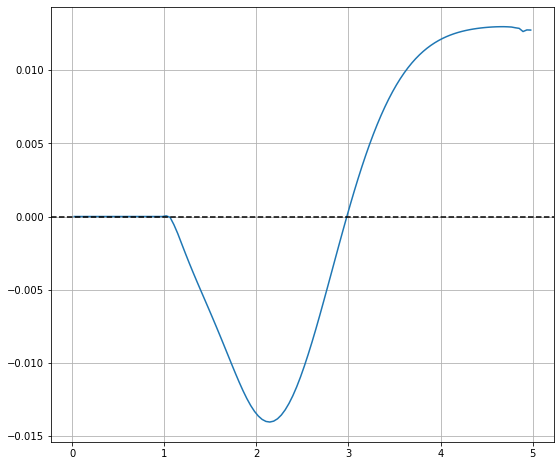

In [30]:
#to determine primary reattachment length

fig,ax=plt.subplots(1,1,figsize=(9,8))
plt.plot(x,U_final[0])
plt.axhline(0,color='k',linestyle='dashed')
plt.grid()
plt.show()

C:\Users\Kangluo See\anaconda3\lib\site-packages\matplotlib\patches.py:3027: RuntimeWarning: invalid value encountered in double_scalars
  cos_t, sin_t = head_length / head_dist, head_width / head_dist


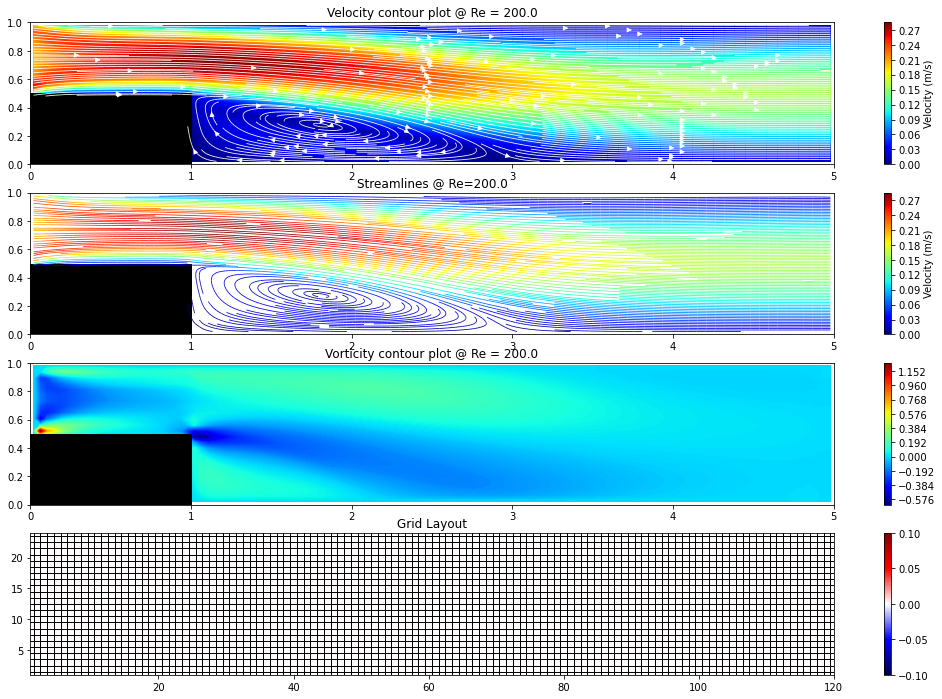

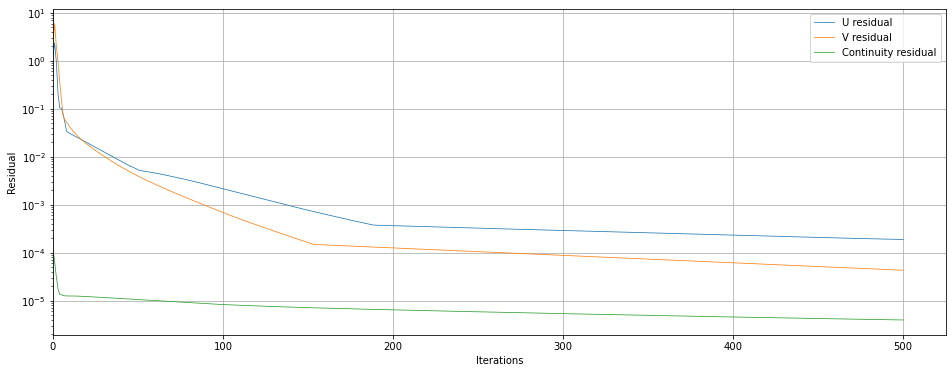

In [31]:
fig,ax=plt.subplots(4,1,figsize=(18,12))
ax[0].streamplot(xx,yy,U_final,V_final,density=2.5,color='white',linewidth=0.8)
graph=ax[0].contourf(xx,yy,V_mag,cmap=cm.jet,levels=255)
ax[0].set_title('Velocity contour plot @ Re = '+str(Re))
fig.colorbar(graph,ax=ax[0],label='Velocity (m/s)')
ax[0].set_xlim(0,L)
ax[0].set_ylim(0,H)

ax[1].streamplot(xx,yy,U_final,V_final,density=3,color=V_mag,cmap=cm.jet,linewidth=0.8,arrowsize=0)
ax[1].set_title('Streamlines @ Re='+str(Re))
fig.colorbar(graph,ax=ax[1],label='Velocity (m/s)')
ax[1].set_xlim(0,L)
ax[1].set_ylim(0,H)

graph=ax[2].contourf(xx,yy,vort,cmap=cm.jet,levels=255)
ax[2].set_title('Vorticity contour plot @ Re = '+str(Re))
fig.colorbar(graph,ax=ax[2])
ax[2].set_xlim(0,L)
ax[2].set_ylim(0,H)

graph=ax[3].pcolormesh(xxe,yye,grid,cmap=cm.seismic,ec='k',shading='auto')
fig.colorbar(graph,ax=ax[3])
ax[3].set_title('Grid Layout')
ax[3].set_xlim(1,Nx)
ax[3].set_ylim(1,Ny)

rect1=patches.Rectangle([0,0],1,0.5,hatch='////',fc='k',ec='k')
rect2=patches.Rectangle([0,0],1,0.5,hatch='////',fc='k',ec='k')
rect3=patches.Rectangle([0,0],1,0.5,hatch='////',fc='k',ec='k')

ax[0].add_patch(rect1)
ax[1].add_patch(rect2)
ax[2].add_patch(rect3)

plt.show()

iterations=np.linspace(0,iter_total,iter_total)
fig,ax=plt.subplots(1,1,figsize=(16,6))
plt.plot(iterations,U_res_list,label='U residual',linewidth=0.75)
plt.plot(iterations,V_res_list,label='V residual',linewidth=0.75)
plt.plot(iterations,Cont_res_list,label='Continuity residual',linewidth=0.75)
plt.xlabel('Iterations')
plt.ylabel('Residual')
ax.set_yscale('log')
plt.grid()
plt.xlim(0)
plt.legend()

plt.show()

In [43]:
def column(matrix, i):
    return np.array([row[i] for row in matrix])

Re=200: RL=2m

# <font color='blue'>Animation</font>

In [89]:
V_mag.shape

(16, 80)

In [21]:
len(U_time_data)

546

In [51]:
U_anim=U_time_data[::20]
V_anim=V_time_data[::20]
count=int(26)

U_file=[]
V_file=[]
V_mag_file=[]

for k in range(count):
    U_final=U_anim[k]
    V_final=V_anim[k] 
    V_mag=np.sqrt(np.power(U_final,2)+np.power(V_final,2))
            
    U_file.append(U_final)
    V_file.append(V_final)
    V_mag_file.append(V_mag)

In [52]:
def animate(k):
    ax.clear()
    
    U_final=U_file[k]
    V_final=V_file[k]
    #V_mag=V_mag_file[k]
    #vort=Vort_file[k]
    plt.title('1 \n''2 \n''Flow time: '+str(round(k*dt*25,3))+' seconds \n' 'Streamlines')
    plt.xlim(0,L)
    plt.ylim(0,H)
    rect1=patches.Rectangle([0,0],2,0.5,hatch='////',fc='k',ec='k')
    ax.add_patch(rect1)
    #contour=plt.contourf(xx,yy,V_mag,cmap=cm.jet,vmax=1.5*u_inlet,levels=255)
    #contour=plt.contourf(xx,yy,vort,cmap=cm.seismic,levels=30,vmax=160)
    stream=plt.streamplot(xx,yy,U_final,V_final,linewidth=0.75,density=1.75,color='k',arrowsize=1)
    return stream

<IPython.core.display.Javascript object>


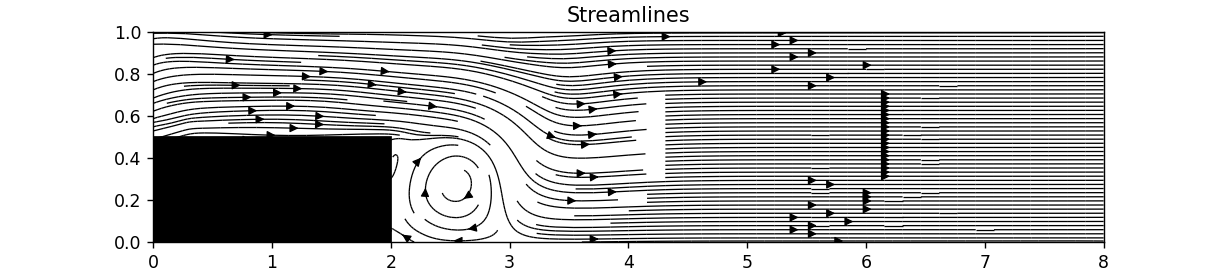

In [53]:
fig,ax=plt.subplots(1,1,figsize=(11,1.6))
plt.xlim(0,L)
plt.ylim(0,H)
x=np.linspace(0,L,Nx)
y=np.linspace(0,H,Ny)
xx,yy=np.meshgrid(x,y)

ani=FuncAnimation(fig,animate,count,interval=400, blit=True)
plt.show()

In [ ]:
print('Help')